# RAG over Evolving Documents

In production RAG systems, documents don't stay still. They get updated, revised, reorganized, and expanded over time.

A typical approach to handling these updates is straightforward but expensive: periodically reprocess your entire document collection from scratch. Every document goes through the full pipeline—partitioning, chunking, embedding, and ingestion—regardless of whether it actually changed.

This works, but it comes with real costs.

If you're processing hundreds or thousands of documents, and each one requires:
- Vision-Language Model inference for partitioning
- Embedding generation for every chunk
- Vector database writes

...then reprocessing everything on every update can quickly become prohibitively expensive. You're paying to re-encode documents that haven't changed at all, just to pick up the handful that did.

For organizations running RAG at scale, this isn't just inefficient, it's a major operational cost and a bottleneck for keeping knowledge bases current.

**What if your system could be smarter?**

What if it could detect which documents actually changed, and only reprocess those—leaving everything else untouched?

That's exactly what we'll look into in this notebook.

We'll use Unstructured's change detection capabilities to create a RAG pipeline that:
- **Tracks document state** across runs
- **Identifies new and modified files** automatically  
- **Skips unchanged documents** entirely
- **Dramatically reduces processing costs** while keeping your knowledge base fresh

By the end, you'll see how a single configuration flag—`reprocess_all: False`—can transform your RAG pipeline from a costly batch reprocessing job into an efficient, delta-aware system.

Let's dive in!

In [1]:
!pip install -U "unstructured-client" astrapy boto3 openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.9/207.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.5/333.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.5/329.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 20.3 MB/s eta 0:00:00


In [2]:
import os
import time
import boto3
from google.colab import userdata
from astrapy import DataAPIClient
from unstructured_client import UnstructuredClient
from openai import OpenAI


def pretty_print_model(response_model):
    print(response_model.model_dump_json(indent=4))

Before we can start building our change-aware RAG pipeline, we need to connect to the Unstructured API.

Unstructured will handle all the heavy lifting of document processing—extracting content from PDFs, chunking text intelligently, and generating embeddings. But more importantly for this tutorial, it also tracks document state across workflow runs, which is what enables our change detection.

Make sure you've signed up for [Unstructured for Developers](https://unstructured.io/?modal=try-for-free) to get your API key.

Once you have your API key, add it to your Colab secrets, and we'll initialize the client.

In [3]:
os.environ["UNSTRUCTURED_API_KEY"] = userdata.get("UNSTRUCTURED_API_KEY")
client = UnstructuredClient(api_key_auth=os.environ["UNSTRUCTURED_API_KEY"])

## Setting Up the S3 Source Connector

Every RAG system starts with data, and in production environments, that data typically lives in cloud storage like Amazon S3.

For this tutorial, we'll be working with a small collection of documents stored in an S3 bucket. These documents will serve as our knowledge base and more importantly, we'll be updating them throughout the tutorial to demonstrate how change detection works in practice.

The Unstructured API makes it easy to connect directly to S3 through a **source connector**. Once configured, this connector will:
- Monitor the specified S3 bucket for documents
- Track which files have been processed
- Detect when files are added, modified, or removed

You'll need to add your AWS credentials to Colab secrets:
- `AWS_ACCESS` - Your AWS access key ID
- `AWS_SECRET` - Your AWS secret access key  
- `S3_REMOTE_URL` - The S3 URI to your bucket (formatted as `s3://my-bucket/` or `s3://my-bucket/my-folder/`)

For more details on S3 authentication options, check out the [Unstructured S3 connector documentation](https://docs.unstructured.io/api-reference/workflow/sources/s3).

Let's set up our source connector:

In [4]:
os.environ["AWS_ACCESS"] = userdata.get("AWS_ACCESS")
os.environ["AWS_SECRET"] = userdata.get("AWS_SECRET")
os.environ["S3_REMOTE_URL"] = userdata.get("S3_REMOTE_URL")

In [5]:
from unstructured_client.models.operations import CreateSourceRequest
from unstructured_client.models.shared import CreateSourceConnector

source_connector_response = client.sources.create_source(
    request=CreateSourceRequest(
        create_source_connector=CreateSourceConnector(
            name="RAG over Evolving Knowledge - Source",
            type="s3",
            config={

                # For AWS access key ID with AWS secret access key authentication:
                "key": os.environ["AWS_ACCESS"],
                "secret": os.environ["AWS_SECRET"],

                "remote_url": os.environ["S3_REMOTE_URL"],
                "recursive": True
            }
        )
    )
)

/usr/local/lib/python3.12/dist-packages/pydantic/functional_validators.py:218: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  function=lambda v, h: h(v),
/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  return self.__pydantic_serializer__.to_python(


## Setting Up the AstraDB Destination Connector

Now that we have our source configured, we need somewhere to store the processed documents and their embeddings. For this, let's use AstraDB.

To set it up:

1. Create a free account at [astra.datastax.com](https://astra.datastax.com/)
2. Create a new **Database**
3. Once it's running, create a **collection** with these settings:
   - Give it a meaningful name (e.g., "rag_documents")
   - For embedding generation method, choose **"Bring my own"** (we'll generate embeddings in our workflow)
   - Set dimensions to **3072** (for OpenAI's `text-embedding-3-large` model)
4. Grab your credentials:
   - API Endpoint
   - Application Token
   - Collection Name
   - Keyspace

Add these to your Colab secrets and we'll configure the destination connector.

For more detailed setup instructions, check out the [AstraDB documentation](https://docs.unstructured.io/api-reference/workflow/destinations/astradb).

In [6]:
os.environ['ASTRA_DB_API_ENDPOINT'] = userdata.get('ASTRA_DB_API_ENDPOINT')
os.environ['ASTRA_DB_APPLICATION_TOKEN'] = userdata.get('ASTRA_DB_APPLICATION_TOKEN')
os.environ['ASTRA_DB_COLLECTION_NAME'] = userdata.get('ASTRA_DB_COLLECTION_NAME')
os.environ['ASTRA_DB_KEYSPACE'] = userdata.get('ASTRA_DB_KEYSPACE')

In [7]:
from unstructured_client.models.operations import CreateDestinationRequest
from unstructured_client.models.shared import (
    CreateDestinationConnector,
    DestinationConnectorType,
    AstraDBConnectorConfigInput
)
destination_connector_response = client.destinations.create_destination(
    request=CreateDestinationRequest(
        create_destination_connector=CreateDestinationConnector(
            name=f"RAG over Evolving Knowledge - Dest",
            type=DestinationConnectorType.ASTRADB,
            config=AstraDBConnectorConfigInput(
                token=os.environ['ASTRA_DB_APPLICATION_TOKEN'],
                api_endpoint=os.environ['ASTRA_DB_API_ENDPOINT'],
                collection_name=os.environ['ASTRA_DB_COLLECTION_NAME'],
                keyspace=os.environ['ASTRA_DB_KEYSPACE'],
                batch_size=20,
                flatten_metadata=False
            )
        )
    )
)

/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='astradb', input_type=str])
  return self.__pydantic_serializer__.to_python(


## Creating the Document Processing Workflow

With our source and destination configured, it's time to define **how** documents should be processed as they flow through the system.

We'll build a workflow with three key processing nodes:

**1. Partitioner**  
This step extracts structured content from raw documents using Unstructured's intelligent **Auto strategy**. Rather than applying a single method to all pages, Auto analyzes each page individually and dynamically selects the most appropriate extraction approach:
- Simple text pages → Fast, rule-based extraction
- Complex layouts (tables, images) → Hi-Res processing, using Object Detection Models and OCR
- Challenging content (scanned, handwritten) → Vision Language Model if needed

This per-page decision-making optimizes both quality and cost—you only pay for advanced processing when it's actually necessary. Auto is the recommended default for most workflows, especially when dealing with diverse document types.

**2. Chunker**  
After partitioning, we break the extracted content into semantically meaningful chunks using the `chunk_by_title` strategy. Good chunking is critical for retrieval quality—chunks need to be small enough to be specific, but large enough to contain complete thoughts. Our configuration preserves section structure and includes overlap between chunks to maintain context.

**3. Embedder**  
Finally, we generate vector embeddings for each chunk using OpenAI's `text-embedding-3-large` model. These numerical representations capture the semantic meaning of the text, enabling similarity search during retrieval.

**The Key to Change Detection:**  
When we create this workflow, we'll set **`reprocess_all: False`**. This single flag tells Unstructured to track which documents have been processed and only reprocess files that are new or have changed since the last run—dramatically reducing costs for subsequent updates.

For more details on partitioning strategies, see the [Auto Strategy documentation](https://docs.unstructured.io/api-reference/workflow/workflows#auto-strategy). For chunking options, check out the [Chunking documentation](https://docs.unstructured.io/api-reference/partition/chunking).

Let's define our workflow nodes:

In [23]:
from unstructured_client.models.shared import (
    WorkflowNode,
    WorkflowType,
    Schedule
)


partition_node = WorkflowNode(
    name="Partitioner",
    subtype="vlm",
    type="partition",
    settings={
        "is_dynamic": True,
        "allow_fast": True,
        "strategy": "auto"
   }
)


chunk_node = WorkflowNode(
    name="Chunker",
    subtype="chunk_by_title",
    type="chunk",
    settings={
        "new_after_n_chars": 200,
        "max_characters": 2048,
        "overlap": 50,
        "combine_text_under_n_chars": 200,
        "multipage_sections": True,
        "include_orig_elements": True,
    }
)

embedder_node = WorkflowNode(
    name='Embedder',
    subtype='azure_openai',
    type="embed",
    settings={
        'model_name': 'text-embedding-3-large'
    }
)



response = client.workflows.create_workflow(
    request={
        "create_workflow": {
            "name": f"RAG over Evolving Knowledge Workflow",
            "source_id": source_connector_response.source_connector_information.id,
            "destination_id": destination_connector_response.destination_connector_information.id,
            "workflow_type": WorkflowType.CUSTOM,
            "workflow_nodes": [
                partition_node,
                chunk_node,
                embedder_node
            ],
            "reprocess_all": False, # To process only new / modified files during subsequent runs
        }
    }
)

workflow_id = response.workflow_information.id
pretty_print_model(response.workflow_information)

{
    "created_at": "2025-11-25T19:27:39.205722Z",
    "destinations": [
        "73a12807-f613-4039-884c-70b9e2201a6a"
    ],
    "id": "4d894467-cba3-464b-90ad-b8dff51bad30",
    "name": "RAG over Evolving Knowledge Workflow",
    "sources": [
        "37775d55-fd94-4b70-88dd-6e62af250168"
    ],
    "status": "active",
    "workflow_nodes": [
        {
            "name": "Partitioner",
            "subtype": "vlm",
            "type": "partition",
            "id": "5cd54e52-2fc9-4a30-829c-f5e101879581",
            "settings": {
                "provider": "anthropic",
                "provider_api_key": null,
                "model": "claude-sonnet-4-20250514",
                "output_format": "text/html",
                "prompt": null,
                "format_html": true,
                "unique_element_ids": true,
                "is_dynamic": true,
                "allow_fast": true,
                "custom_host_config": null
            }
        },
        {
            "na

## Running the workflow

Now that we've defined how we want to process our data, let's start the workflow and wait for it to complete:

In [24]:
def run_workflow(workflow_id):
    response = client.workflows.run_workflow(
        request={
            "workflow_id": workflow_id,
        }
    )

    pretty_print_model(response.job_information)

    return response.job_information.id

job_id = run_workflow(workflow_id)

{
    "created_at": "2025-11-25T19:27:40.907815Z",
    "id": "a7e3c028-cd86-4a59-bcc1-1f2ba25431af",
    "status": "SCHEDULED",
    "workflow_id": "4d894467-cba3-464b-90ad-b8dff51bad30",
    "workflow_name": "RAG over Evolving Knowledge Workflow",
    "job_type": "ephemeral"
}


Now that we've created and started a job, we can poll Unstructured's `get_job` endpoint and check for its status every 30s till completion

In [25]:
def poll_job_status(job_id, wait_time=30):
    while True:
        response = client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print(f"Job is scheduled, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        elif job.status == "IN_PROGRESS":
            print(f"Job is in progress, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print("Job is completed")
            break

    return job

job = poll_job_status(job_id)
pretty_print_model(job)

Job is scheduled, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-11-25T19:27:40.907815",
    "id": "a7e3c028-cd86-4a59-bcc1-1f2ba25431af",
    "status": "COMPLETED",
    "workflow_id": "4d894467-cba3-464b-90ad-b8dff51bad30",
    "workflow_name": "RAG over Evolving Knowledge Workflow",
    "job_type": "ephemeral",
    "runtime": "PT0S"
}


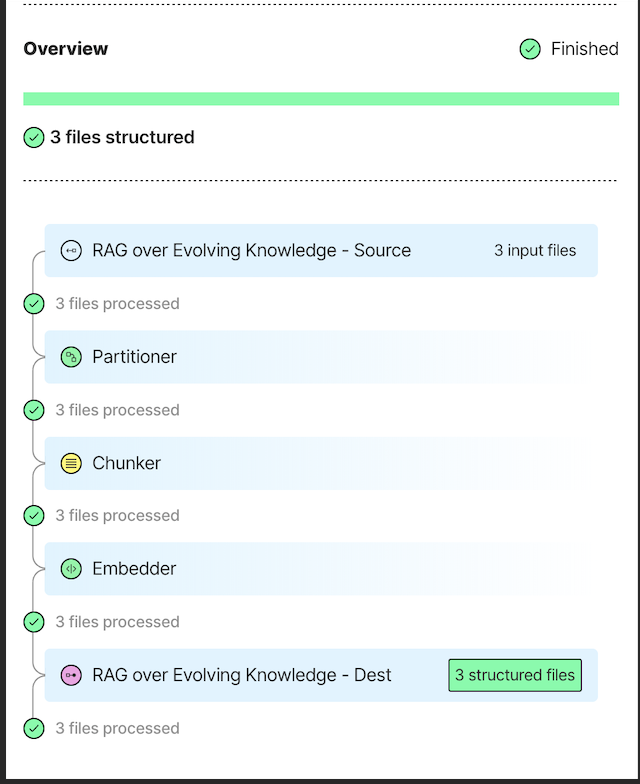

At this point, we've successfully run our workflow for the first time and processed our initial set of documents. As expected, all 3 files in our S3 bucket went through partitioning, chunking, embedding, and right into AstraDB.

This is exactly what should happen on the first run: there's no prior state, so everything needs to be processed.

But here's where things get interesting.

In a traditional RAG setup, every time you want to refresh your knowledge base—whether you're adding a single new document or updating just one file—you'd have to reprocess everything. That means paying for documents that haven't changed at all.

With change detection enabled (`reprocess_all: False`), we can do better.

**In the next section, we'll see change detection in action:**
- We'll add a brand new document to our S3 bucket
- We'll update an existing document with new content
- And we'll watch as the system processes only what actually changed without making a dent in your wallet 😉

## How Change Detection Works Under the Hood

Before we dive into the demo, let's take a quick look at how Unstructured's change detection actually works.

When you set `reprocess_all: False`, Unstructured keeps track of every document it processes by storing metadata about each file—things like filename, last modified timestamp, and a content hash. On subsequent workflow runs, here's what happens:


1. **Scan Source**: The workflow connects to your S3 source and lists all available documents
2. **Check Status**: For each document, Unstructured checks:
   - Is this a new file we've never seen?
   - Has the file been modified since we last processed it?
   - Is it unchanged from our last run?
3. **Smart Processing**:
   - New or modified files → Full processing pipeline (partition, chunk, embed, ingest)
   - Unchanged files → Skipped entirely
4. **State Tracking**: After processing, Unstructured updates its internal records with the new document versions

This means you only pay for what actually changed. If you have 1,000 documents and update just 5 of them, only those 5 go through the pipeline.

Now let's see this in action with a real example.

In [26]:
with open('delta-aware-rag-demo.md', 'w') as f:
    f.write("""

# Document Evolution and Information Retrieval Systems

## Understanding Document Lifecycles

Documents in enterprise environments don't remain static. They evolve through various stages, from creation to deprecation. Understanding how documents change and how retrieval systems interact with these changes is fundamental to building robust information systems. In many cases, documents don't evolve incrementally—they get completely rewritten. Understanding how retrieval systems handle wholesale document rewrites is critical to maintaining accurate and useful information systems.

## Types of Document Evolution

### Content Rewrites
In many scenarios, documents aren't edited incrementally. Instead, they're completely rewritten from scratch. This happens when documentation for a new major version is written, when a research paper is substantially revised, or when a product's approach to explaining something fundamentally changes. A complete rewrite means the old explanation, examples, structure, and organization are discarded entirely. The new version takes a different approach to the same topic.

Complete rewrites differ fundamentally from incremental edits. When you fix a typo or add a clarification, you're modifying existing content. When you rewrite a document, you're replacing it entirely. The old content becomes irrelevant because the new version presents the information differently, covers different aspects, and is based on a different understanding or context.

### Structural Reorganization
Documents might be reorganized significantly. A guide organized by feature might be reorganized by user role. A reference manual might shift from alphabetical ordering to conceptual grouping. These structural changes can be so substantial that they constitute a rewrite, even if some content is preserved. A user familiar with the old structure will struggle with the new organization, and the old structure becomes unhelpful.

### Technology and Context Changes
Documents become outdated not just when their content is wrong, but when the context in which they apply changes. A guide for using a software library becomes less useful when the library undergoes a major redesign, even if the basic information would technically still apply. The examples won't match the new interface. The recommended approaches will be outdated. The document needs a complete rewrite to reflect the new reality.

## Challenges in Retrieval Systems

### Staleness Problem
When documents change, systems that rely on pre-computed representations face challenges. If a system indexed a document at a point in time, subsequent changes aren't reflected in the index. A user searching for information might retrieve outdated content without realizing the document has been updated. This problem is especially acute when documents are completely rewritten. A retrieval system returning content from a completely outdated version of a document provides actively incorrect information.

### Complete Replacement vs. Incremental Updates
The fundamental challenge with completely rewritten documents is that they're not edits to be merged—they're replacements. When a document is rewritten, there's no point in keeping the old version indexed in the active retrieval system. Users searching for current information should find the new version, not the old one. Older versions might be valuable for historical or archival purposes, but they don't belong in a retrieval system designed to provide current information.

### Cost of Reprocessing
When a document is completely rewritten, it needs complete reprocessing. The system must parse it, encode it, generate embeddings, and index it entirely from scratch. The old version must be removed from the index. This is an expensive operation in terms of computational resources, time, and financial cost. Organizations need to balance the desire to maintain current content against the costs of processing updates.

The challenge isn't minor—if you have hundreds or thousands of documents and each complete rewrite requires full reprocessing, costs accumulate quickly. Systems need efficient ways to identify which documents have been rewritten so they can reprocess only what's necessary, not constantly reprocessing the entire collection.
""")

print("File created: delta-aware-rag-demo.md")

File created: delta-aware-rag-demo.md


We've created a new markdown file called `delta-aware-rag-demo.md` that discusses document evolution and information retrieval challenges. Now let's upload it to S3 and run our workflow to see change detection in action.

In [27]:
def upload_file_to_s3(file_name):
  '''
  Uploads a file to S3.
  '''

  bucket = os.environ['S3_REMOTE_URL'].split('/')[2]
  path = '/'.join(os.environ['S3_REMOTE_URL'].split('/')[3:])

  s3 = boto3.client('s3', aws_access_key_id=os.environ.get('AWS_ACCESS'), aws_secret_access_key=os.environ['AWS_SECRET'])
  with open(file_name, 'rb') as f:
      s3.put_object(Bucket=bucket, Key=f'{path}{file_name}', Body=f)

  print(f"Uploaded {file_name} to S3")


upload_file_to_s3('delta-aware-rag-demo.md')

Uploaded delta-aware-rag-demo.md to S3


In [28]:
job_id = run_workflow(workflow_id)
job = poll_job_status(job_id)
pretty_print_model(job)

{
    "created_at": "2025-11-25T19:35:40.804728Z",
    "id": "8cb498e2-a90c-4591-b3f0-fb958e9696df",
    "status": "SCHEDULED",
    "workflow_id": "4d894467-cba3-464b-90ad-b8dff51bad30",
    "workflow_name": "RAG over Evolving Knowledge Workflow",
    "job_type": "ephemeral"
}
Job is scheduled, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-11-25T19:35:40.804728",
    "id": "8cb498e2-a90c-4591-b3f0-fb958e9696df",
    "status": "COMPLETED",
    "workflow_id": "4d894467-cba3-464b-90ad-b8dff51bad30",
    "workflow_name": "RAG over Evolving Knowledge Workflow",
    "job_type": "ephemeral",
    "runtime": "PT0S"
}


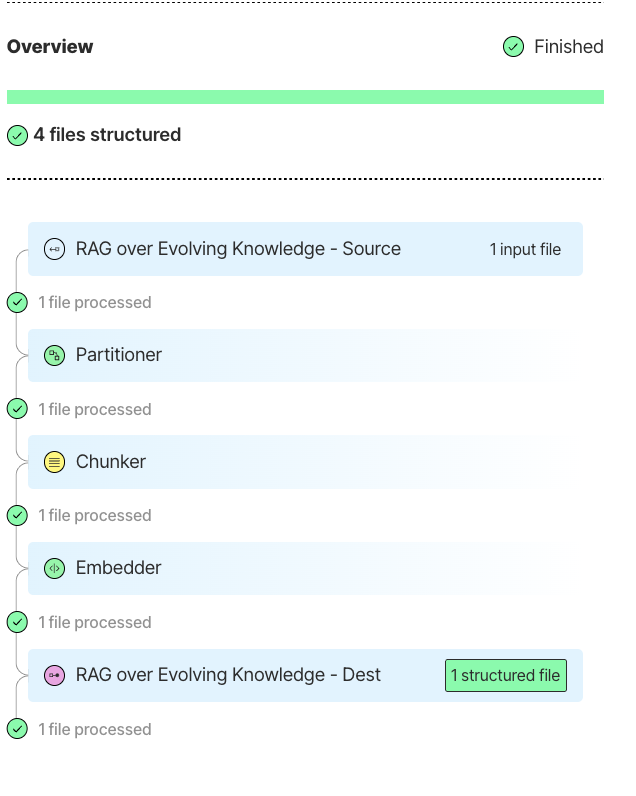

After uploading our new file to S3 and running the workflow, take a look at what happened:

**Only 1 file was processed.**

Even though our S3 bucket now contains 4 total documents, Unstructured recognized that 3 of them were already processed in the previous run. It detected the new file (`delta-aware-rag-demo.md`), processed only that one, and skipped everything else.


Now let's verify that our newly added document is actually available in our RAG system by asking a question about its content:

For this section, you'll need your OpenAI API Key for the embedding and generation section. Once that has been added, let's go to the next part


In [47]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
EMBEDDING_MODEL = "text-embedding-3-large"
LLM_MODEL = "gpt-4o"
TOP_K = 5

Now let's set up a simple RAG pipeline to verify our documents are accessible. First, we'll establish a connection to AstraDB where our processed documents and embeddings are stored.

Then we'll define a few basic functions:

**`get_embedding(text)`** - Generates vector embeddings using OpenAI's `text-embedding-3-large` model

**`enhanced_retriever(query, n)`** - Searches our vector database for the most relevant document chunks based on semantic similarity

**`generate(context, question)`** - Takes retrieved context and generates an answer using GPT-4o

**`rag_pipeline(question)`** - Ties everything together: retrieves relevant chunks, then generates a grounded answer

In [30]:

astra_client = DataAPIClient(os.environ["ASTRA_DB_APPLICATION_TOKEN"])
database = astra_client.get_database(os.environ["ASTRA_DB_API_ENDPOINT"])
COLLECTION = database.get_collection(
    name=os.environ["ASTRA_DB_COLLECTION_NAME"],
    keyspace=os.environ["ASTRA_DB_KEYSPACE"]

)

def get_embedding(text: str):
    """Generate embedding using OpenAI's text-embedding-3-large model"""
    response = openai_client.embeddings.create(
        model=EMBEDDING_MODEL,
        input=text
    )
    return response.data[0].embedding


def enhanced_retriever(query: str, n: int = TOP_K):
    """Enhanced retriever that returns documents with metadata"""
    embedding = get_embedding(query)
    results = COLLECTION.find(sort={"$vector": embedding}, limit=n)

    retrieved_docs = []
    for doc in results:
        retrieved_docs.append({
            "content": doc.get("content", ""),
            "source": doc["metadata"]["metadata"]["filename"]
        })

    sources = set([d["source"] for d in retrieved_docs])

    context = "\n".join(f"[Source: {d['source']}]\n{d['content']}" for d in retrieved_docs)
    return context

In [41]:
openai_client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def generate(context: str, question: str):
    """Generate answer using context and question"""
    prompt = f"""You are a helpful assistant. Answer the question based on the provided context.

Context:
{context}

Question: {question}

Answer:"""

    response = openai_client.chat.completions.create(
        model=LLM_MODEL,
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.0
    )
    return response.choices[0].message.content


def rag_pipeline(question: str):
    """Complete RAG pipeline: retrieve context and generate answer"""
    context = enhanced_retriever(question)
    answer = generate(context, question)
    return answer


In [44]:
print(rag_pipeline("What challenges does document evolution bring in?"))


Document evolution brings several challenges, particularly for information retrieval systems:

1. **Staleness Problem**: When documents are updated or completely rewritten, retrieval systems that rely on pre-computed representations may not reflect these changes. This can lead to users retrieving outdated content, which is especially problematic when documents have been completely rewritten, as it can result in providing actively incorrect information.

2. **Complete Replacement vs. Incremental Updates**: Completely rewritten documents are not just edits but replacements. The old version should not remain indexed in the active retrieval system, as users need access to the most current information. While older versions might be useful for historical or archival purposes, they are not suitable for systems designed to provide current information.

3. **Cost of Reprocessing**: When a document is completely rewritten, it requires full reprocessing, including parsing, encoding, generating em

Perfect! Our RAG system successfully retrieved information from the newly added document. The answer references content about document evolution types that we just uploaded, confirming that change detection worked and the new file is now searchable.

Now let's test the other side of change detection: what happens when we modify an existing document? We'll update our file by appending new content , upload it back to S3, and see if the system detects the change and reprocesses only that one file.

In [45]:
# update file
with open('delta-aware-rag-demo.md', 'a') as f:
    f.write("""## Updated Section\n
## Information Retrieval Approaches

### Full Reprocessing Strategy
Some systems handle document evolution by periodically reprocessing the entire collection. At set intervals, all documents are re-indexed, re-encoded, or re-embedded from scratch. This guarantees that all content is current but can be resource-intensive. The frequency of reprocessing represents a tradeoff between freshness and cost. Some systems do this daily, others weekly. The choice depends on how frequently documents change and how critical current content is.

### Change Detection and Selective Reprocessing
Rather than constantly reprocessing everything, systems can track which documents have actually changed and reprocess only those. This requires maintaining metadata about previously processed documents. The system might store content hashes from the last processing run. On the next run, it computes hashes for current documents and compares them. Documents with different hashes have changed—whether through minor edits or complete rewrites—and need reprocessing. Documents with matching hashes are left alone.

This approach is especially valuable when documents are completely rewritten. The system detects that a rewrite has occurred through hash mismatch, triggers reprocessing of that specific document, removes the old version from the index, and adds the new version. Meanwhile, unchanged documents are never touched, saving computational resources.

### Immediate Updates on Document Change
Some systems take a more reactive approach. When a document is written or updated, the system immediately reprocesses it. This might be triggered by a webhook, an API call, or a monitoring system that detects changes. Instead of waiting for periodic batch processing, the system keeps the index current as documents change. This requires more constant processing but ensures the retrieval system is always current.

This approach works well when documents are explicitly marked as changed or when the system has real-time access to document sources. As soon as a document is rewritten, it's flagged for reprocessing and the index is updated.
""")



upload_file_to_s3('delta-aware-rag-demo.md')

Uploaded delta-aware-rag-demo.md to S3


Running the Workflow to automatically detect any changes and process them

In [46]:
job_id = run_workflow(workflow_id)
job = poll_job_status(job_id)
pretty_print_model(job)

{
    "created_at": "2025-11-25T19:45:27.829065Z",
    "id": "2d9cc9ea-da53-4b0c-9a26-70121ef19e3d",
    "status": "SCHEDULED",
    "workflow_id": "4d894467-cba3-464b-90ad-b8dff51bad30",
    "workflow_name": "RAG over Evolving Knowledge Workflow",
    "job_type": "ephemeral"
}
Job is scheduled, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-11-25T19:45:27.829065",
    "id": "2d9cc9ea-da53-4b0c-9a26-70121ef19e3d",
    "status": "COMPLETED",
    "workflow_id": "4d894467-cba3-464b-90ad-b8dff51bad30",
    "workflow_name": "RAG over Evolving Knowledge Workflow",
    "job_type": "ephemeral",
    "runtime": "PT0S"
}


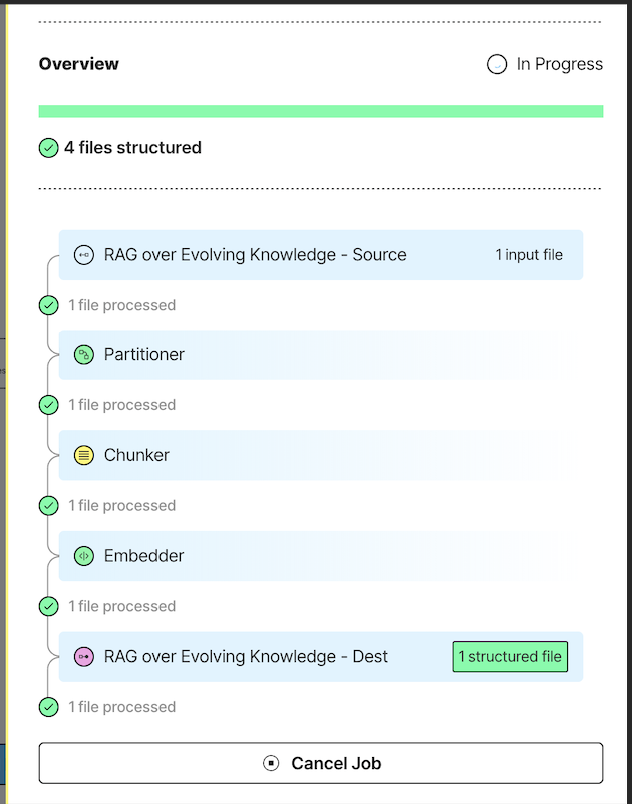

In [48]:
print(rag_pipeline("What are different approaches for Information Retrieval?"))

Different approaches for Information Retrieval, as described in the context, include:

1. **Full Reprocessing Strategy**: This approach involves periodically reprocessing the entire document collection. All documents are re-indexed, re-encoded, or re-embedded from scratch at set intervals. This ensures that all content is current but can be resource-intensive. The frequency of reprocessing is a tradeoff between freshness and cost.

2. **Change Detection and Selective Reprocessing**: Instead of reprocessing everything, this approach tracks which documents have changed and reprocesses only those. It involves maintaining metadata about previously processed documents, such as content hashes. When a document's hash changes, it indicates a change, triggering reprocessing of that specific document.

3. **Immediate Updates on Document Change**: This reactive approach reprocesses documents immediately when they are written or updated. It can be triggered by a webhook, an API call, or a monitori

Excellent! Once again, only 1 file was processed. The system detected that this file had changed, reprocessed it through the pipeline, and left the other 3 documents untouched.

When we query our RAG system now, we get answers that include the newly added content about information retrieval approaches. Change detection worked perfectly for both adding new files and updating existing ones.

## Taking It Further: Scheduled Workflows

Right now, we've been manually triggering workflow runs to demonstrate change detection. But in production, you probably want this to happen automatically.

Unstructured supports **scheduled workflows** that can run on a regular cadence—hourly, daily, or whatever interval makes sense for your use case. You can set up a schedule so that your RAG system automatically checks for document changes and processes only what's new or modified, without any manual intervention.

The best part? You still only pay for the documents that actually get processed. If nothing changed since the last run, the workflow completes almost instantly with zero processing costs 🙂

Check out the [Workflows documentation](https://docs.unstructured.io/api-reference/workflow/workflows) to see how you can set up schedules and integrate this into your production systems.

## Wrapping Up

In this notebook, we've built a cost-efficient, delta-aware RAG pipeline that:
- Tracks document state across runs
- Automatically detects new and modified files
- Skips unchanged documents entirely
- Dramatically reduces processing costs while keeping your knowledge base current

Change detection isn't just a nice-to-have feature. For organizations running RAG at scale, it's essential for controlling costs and maintaining sustainable operations.

With Unstructured's `reprocess_all: False` flag and intelligent state tracking, you get all the benefits of a fresh, up-to-date knowledge base without the expense of constant full reprocessing.

Ready to build your own delta-aware RAG system? Grab your [Unstructured API key](https://unstructured.io/?modal=try-for-free) and start processing!